## Auburn, AL 2022 City Council Election Results and Boundaries

### Sections
- <a href="#join">Read in Input Files and Join</a><br>
- <a href="#shp">Create Ward Boundaries</a><br>
- <a href="#maup">Join with Election Returns</a><br>
- <a href="#exp">Export Cleaned Precinct-Level Datasets</a><br>

#### Sources

- [Auburn, AL 2022 Municipal Election Returns, Ward Level PDF](https://www.auburnalabama.org/elections/results/) 
- [Auburn, AL Voting Wards PDF](https://static.auburnalabama.org/media/apps/www/elections/voting-locations/VotingWards.pdf)
- [Auburn, AL 2024 City Limits SHP](https://data-coa.opendata.arcgis.com/maps/5a4388c75bcb4487b4444cfd17a1a33e)
- [RDH Alabama 2020 Census Block Boundaries](https://redistrictingdatahub.org/dataset/alabama-block-boundaries-2020/)
-[Census Place Boundaries for City of Auburn](https://data.census.gov/map/160XX00US0103076?layer=VT_2022_160_V2_PY_D1&loc=43.3751,-113.1138,z4.0000)

In [1]:
import pandas as pd
import geopandas as gp
import os
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

<p><a name="join"></a></p>

### Read in input files

Election returns were transcribed from PDF to machine readable format, and checked for accuracy.

In [2]:
#Election Returns
er = pd.read_csv("./raw-from-source/AL22_AUBURN_ER")
er.head(2)

,UNIQUE_ID,MNCIPAL,WARD,GCTC1NFIT,GCTC1NDOW,GCTC2NGRI,GCTC2NWES,GCTC5NMOR,GCTC5NLEV,GCTC5NWEL,GCTC6NPAR,GCTC6NPOL,GCTC7NCOB,GCTC7NLAN
0,AUBURN-CITYCOUNC-W1,AUBURN-CITYCOUNC,1,216,91,0,0,0,0,0,0,0,0,0
1,AUBURN-CITYCOUNC-W2,AUBURN-CITYCOUNC,2,0,0,385,242,0,0,0,0,0,0,0


In [3]:
#Alabama 2020 Census blocks
alblocks = gp.read_file("./raw-from-source/al_b_2020_bound/al_b_2020_bound.shp")
# Subset to just Lee County, FIP code 081
leeblocks = alblocks[alblocks['COUNTYFP20'] == '081'][['GEOID20', 'geometry']]

<AxesSubplot:>

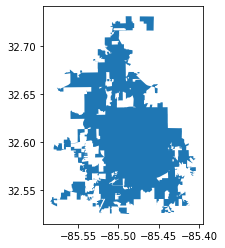

In [4]:
#Census Place Auburn boundaries
shp = gp.read_file("./raw-from-source/tl_2020_01_place/tl_2020_01_place.shp")
auburn = shp[shp['NAME'] == 'Auburn']
auburn.plot()

In [5]:
#Clip Lee County blocks to Auburn, AL boundaries from Census
clipped = gp.clip(leeblocks, auburn.geometry)
len(clipped.GEOID20.unique()) # number of unique census blocks
# auburn = gp.sjoin(leeblocks, auburn, op='within', how='inner')

1159

In [6]:
city_limits = gp.read_file("./raw-from-source/City_Limits/City_Limits.shp")

In [7]:
#Three line gdf for city limits, limiting to rows of interest
citylim24 = city_limits.iloc[[0,1]]
citylim24 = citylim24.to_crs('EPSG:4269')

<AxesSubplot:>

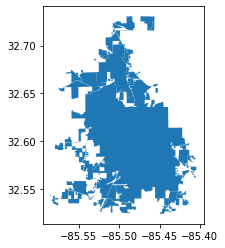

In [8]:
citylim24.plot()

<p><a name="shp"></a></p>

### Create Ward Boundaries and Block Assignment File
In QGIS, PDF map of ward boundaries was georeferenced.
Lee County 2020 Census blocks were overlaid, and each ward shape was created by selecting
1. Every census block that was wholly contained within ward shape for all 8 wards
2. Every census block that was partially contained within ward shapes for four wards [3,4,7,8]

In [9]:
#Reading in shapefiles with only wholly contained blocks
wards = {}
for i in range(1, 9):
    wards[f'ward{i}'] = gp.read_file(f"./raw-from-source/wards/auburn_w{i}.geojson")

In [10]:
for i in range(1, 9):
    globals()[f"ward{i}"] = wards[f"ward{i}"]

In [11]:
# Create an initial BAF for wholly contained blocks
baf = pd.concat([globals()[f'ward{i}'][['GEOID20']].assign(WARD=i) for i in range(1, 9)])
# add column for partial blocks
baf['PARTIAL_BLOCK'] = 0

In [12]:
#Check for duplicates
baf[baf['GEOID20'].duplicated()]

,GEOID20,WARD,PARTIAL_BLOCK


#### Clip extra blocks to census place auburn shapefile

In [13]:
#Read in GEOJSONs for additional census blocks that are partially contained within auburn city council ward boundaries
extra_wards = {}
for i in [3, 4, 7, 8]:
    extra_wards[f'ward{i}_ex'] = gp.read_file(f"./raw-from-source/wards/auburn_w{i}_extra.geojson")

In [14]:
for i in [3, 4, 7, 8]:
    globals()[f"ward{i}_ex"] = extra_wards[f"ward{i}_ex"]

In [15]:
#Clip to the citylimits 2024 shapefile
clipped_wards = {}
for ward, ward_ex in zip([3, 4, 7, 8], [ward3_ex, ward4_ex, ward7_ex, ward8_ex]):
    clipped_wards[f'w{ward}_clip'] = gp.clip(ward_ex, citylim24.iloc[[1]].geometry)
for i in [3, 4, 7, 8]:
    globals()[f"w{i}_clip"] = clipped_wards[f"w{i}_clip"]

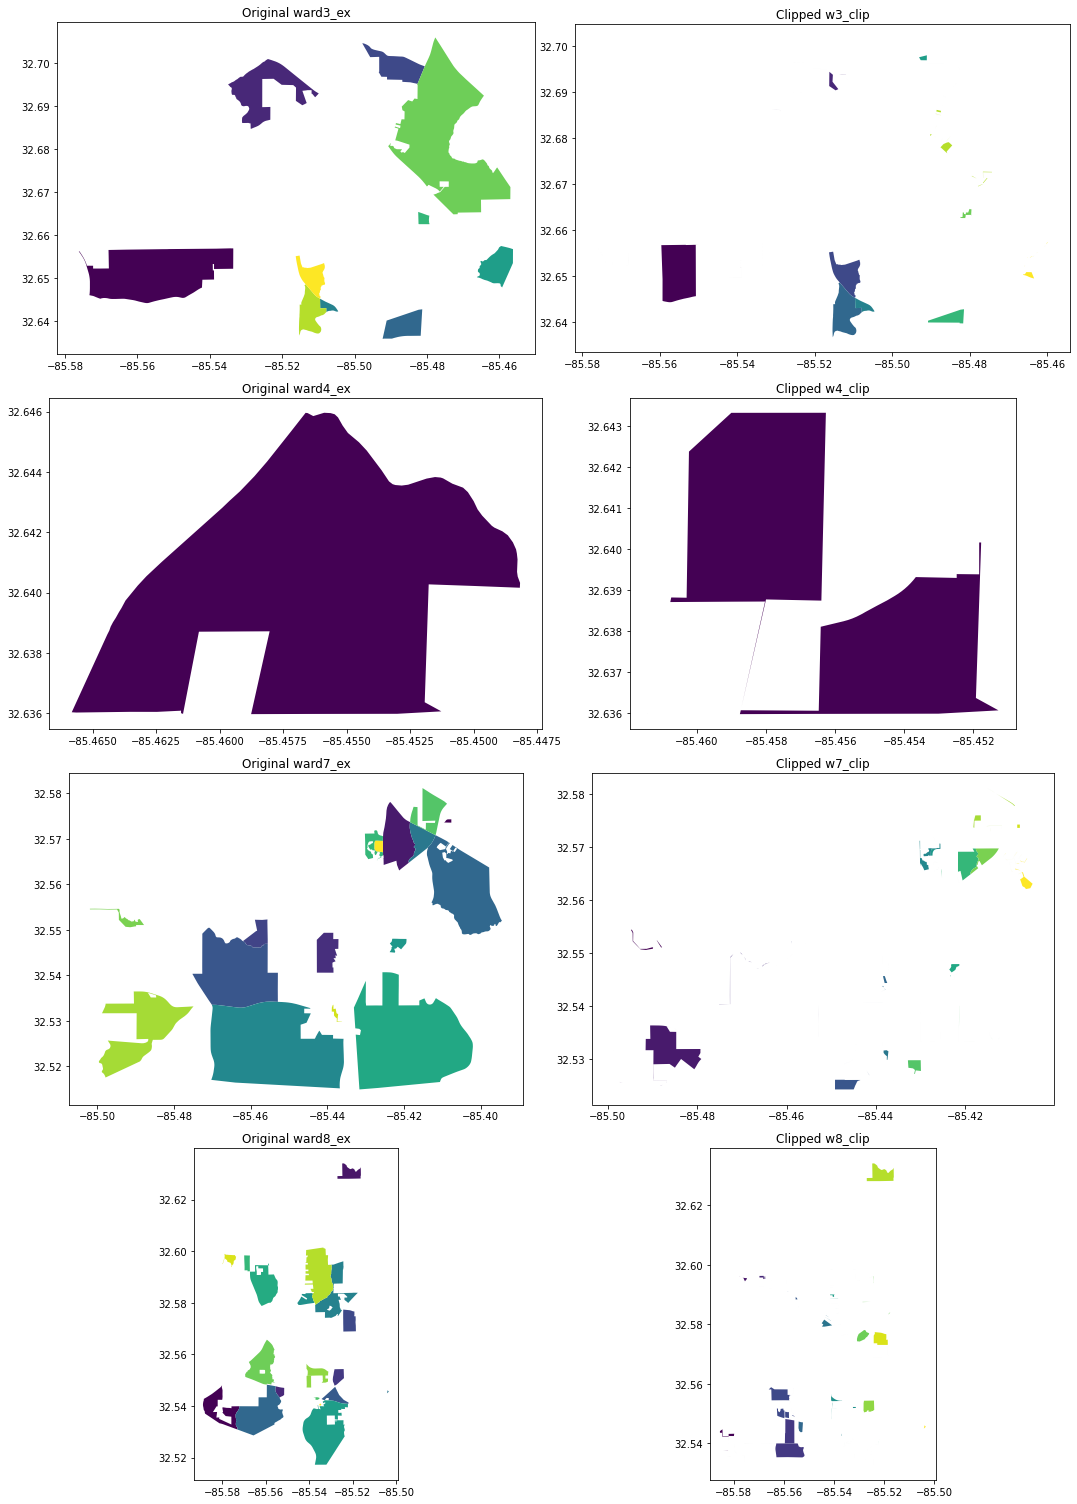

In [16]:
fig, axs = plt.subplots(4, 2, figsize=(15, 21))

# Plot for ward 3
ward3_ex.plot(ax=axs[0, 0], cmap='viridis')
axs[0, 0].set_title('Original ward3_ex')

w3_clip.plot(ax=axs[0, 1], cmap='viridis')
axs[0, 1].set_title('Clipped w3_clip')

# Plot for ward 4
ward4_ex.plot(ax=axs[1, 0], cmap='viridis')
axs[1, 0].set_title('Original ward4_ex')

w4_clip.plot(ax=axs[1, 1], cmap='viridis')
axs[1, 1].set_title('Clipped w4_clip')

# Plot for ward 7
ward7_ex.plot(ax=axs[2, 0], cmap='viridis')
axs[2, 0].set_title('Original ward7_ex')

w7_clip.plot(ax=axs[2, 1], cmap='viridis')
axs[2, 1].set_title('Clipped w7_clip')

# Plot for ward 8
ward8_ex.plot(ax=axs[3, 0], cmap='viridis')
axs[3, 0].set_title('Original ward8_ex')

w8_clip.plot(ax=axs[3, 1], cmap='viridis')
axs[3, 1].set_title('Clipped w8_clip')

plt.tight_layout()
plt.show()

In [17]:
# Add partial blocks to a new baf
clip_baf = pd.concat([
    w3_clip[['GEOID20']].assign(WARD=3),
    w4_clip[['GEOID20']].assign(WARD=4),
    w7_clip[['GEOID20']].assign(WARD=7),
    w8_clip[['GEOID20']].assign(WARD=8)])

clip_baf['PARTIAL_BLOCK'] = 1

In [18]:
#Concat into a final baf
AL22_AUBURN_BAF = pd.concat([baf, clip_baf])
#check
AL22_AUBURN_BAF['PARTIAL_BLOCK'].value_counts()

0    857
1     46
Name: PARTIAL_BLOCK, dtype: int64

In [19]:
# For wards with some partial census blocks, consolidate before dissolving
ward3com = pd.concat([ward3, w3_clip,])
ward4com = pd.concat([ward4, w4_clip,])
ward7com = pd.concat([ward7, w7_clip,])
ward8com = pd.concat([ward8, w8_clip,])

In [20]:
#Dissolve blocks into draft ward shapes
ward_nums = [1, 2, 3, 4, 5, 6, 7, 8]
ward_data = {
    1: ward1, 2: ward2, 3: ward3com, 4: ward4com,
    5: ward5, 6: ward6, 7: ward7com, 8: ward8com
}

ward_dissolved = {}
for ward_num in ward_nums:
    dissolved = ward_data[ward_num].dissolve()[['geometry']]
    dissolved['UNIQUE_ID'] = f'AUBURN-CITYCOUNC-W{ward_num}'
    ward_dissolved[ward_num] = dissolved

auburn_wards = pd.concat(ward_dissolved.values())
#switch order
auburn_wards = auburn_wards[['UNIQUE_ID', 'geometry']]

<AxesSubplot:>

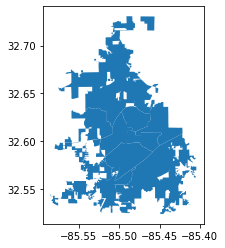

In [21]:
auburn_wards.plot()

Export, and inspect in QGIS, for differences between 2024 shape and 2022 ward boundaries

In [22]:
# use this to check shapes
# auburn_wards.to_file("check.shp")

Edits made for two wards in QGIS, using vertex tool - Ward 3 and Ward 8

In [23]:
#Read in edited shapes, and replace
ward3_edit = gp.read_file("./raw-from-source/wards/auburn_w3_edits.geojson")
ward3_edit = ward3_edit[['UNIQUE_ID', 'geometry']]
ward8_edit = gp.read_file("./raw-from-source/wards/auburn_w8_edits.geojson")

In [24]:
#make final ward file
auburn_wards_final = pd.concat([
    auburn_wards[~auburn_wards['UNIQUE_ID'].isin(['AUBURN-CITYCOUNC-W3', 'AUBURN-CITYCOUNC-W8'])],
    ward3_edit,
    ward8_edit])

<AxesSubplot:>

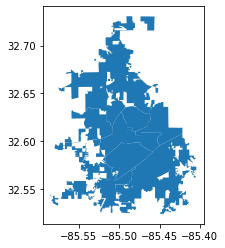

In [25]:
auburn_wards_final.plot()

<p><a name="maup"></a></p>

### Join with Election Returns

In [26]:
er.head(1)

,UNIQUE_ID,MNCIPAL,WARD,GCTC1NFIT,GCTC1NDOW,GCTC2NGRI,GCTC2NWES,GCTC5NMOR,GCTC5NLEV,GCTC5NWEL,GCTC6NPAR,GCTC6NPOL,GCTC7NCOB,GCTC7NLAN
0,AUBURN-CITYCOUNC-W1,AUBURN-CITYCOUNC,1,216,91,0,0,0,0,0,0,0,0,0


In [27]:
# merge
auburn_pber = er.merge(auburn_wards_final, on='UNIQUE_ID', how = 'right', indicator=True)

In [28]:
#check indicator to see if merge was successful
auburn_pber._merge.value_counts()

both          5
right_only    3
left_only     0
Name: _merge, dtype: int64

In [29]:
#Drop merge column
auburn_pber.drop(labels = ['_merge'], axis = 1, inplace = True)

In [30]:
#clean up
auburn_pber['MNCIPAL'] = 'Auburn City'
auburn_pber = auburn_pber.fillna(0)

In [31]:
auburn_pber.head(1)

,UNIQUE_ID,MNCIPAL,WARD,GCTC1NFIT,GCTC1NDOW,GCTC2NGRI,GCTC2NWES,GCTC5NMOR,GCTC5NLEV,GCTC5NWEL,GCTC6NPAR,GCTC6NPOL,GCTC7NCOB,GCTC7NLAN,geometry
0,AUBURN-CITYCOUNC-W1,Auburn City,1.0,216.0,91.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-85.49041 32.61529, -85.49041 32.614..."


In [32]:
#reorder df
auburn_pber_final = auburn_pber[['UNIQUE_ID', 'MNCIPAL', 'WARD','GCTC1NFIT', 'GCTC1NDOW', 'GCTC2NGRI', 'GCTC2NWES', 'GCTC5NMOR',
       'GCTC5NLEV', 'GCTC5NWEL', 'GCTC6NPAR', 'GCTC6NPOL', 'GCTC7NCOB',
       'GCTC7NLAN','geometry']]

In [33]:
# make sure gdf
auburn_pber_final = gp.GeoDataFrame(auburn_pber_final, geometry='geometry', crs='EPSG:4326')

In [34]:
#check
type(auburn_pber_final)

geopandas.geodataframe.GeoDataFrame

<AxesSubplot:>

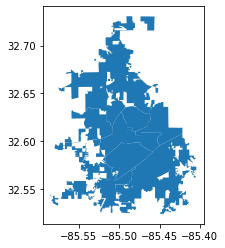

In [35]:
auburn_pber_final.plot()

<p><a name="exp"></a></p>

### Export Cleaned Precinct-Level Datasets

In [36]:
if not os.path.exists("./AL22_AUBURN_PBER/"):
    os.mkdir("./AL22_AUBURN_PBER/")

auburn_pber_final.to_file("./AL22_AUBURN_PBER/AL22_AUBURN_PBER/AL22_AUBURN_PBER.shp")
AL22_AUBURN_BAF.to_csv('./AL22_AUBURN_PBER/AL22_AUBURN_BAF.csv', index=False)

In [37]:
def check_file(path):
    if ".csv" in path:
        file_type = ".csv"
        load = pd.read_csv(path)
    elif ".shp" in path:
        file_type = ".shp"
        load = gp.read_file(path)
        assert(os.path.exists(path[0:-4] + ".cpg"))
        assert(os.path.exists(path[0:-4] + ".dbf"))
        assert(os.path.exists(path[0:-4] + ".prj"))
        assert(os.path.exists(path[0:-4] + ".shx"))
    else:
        raise ValueError ("Other function needed to load non .csv or .shp")
    run_checks(load, path, file_type)
    
def run_checks(file, path, file_type):
    if "/Users" in path:
        path = path.replace("/Users","")
    path_name = path.replace("/","-")
    
        
    with open("./FILE_CHECK" + path_name + ".txt","w") as t:
        t.write("***RDH FILE CHECKER***\n")
        t.write("Checking file located at " + path+"\n")
        t.write("\n")
        t.write("\n")        
        
        t.write("***N/A VALUES***\n")
        if(file.isna().any().sum() != 0):
            t.write("N/A values in the following columns\n")
            for col in file.columns:
                num_nas = file[col].isna().sum()
                string_nans = file[file[col]=="nan"].shape[0]
                if file[col].isna().any().sum():
                    t.write("\t"+col+" - "+ str(num_nas) +" row(s)\n")
                elif  string_nans > 0:
                    t.write("\t"+col+" - "+ str(string_nans) +" row(s)\n")

        else:
            t.write("Do not appear to be N/A values")
        t.write("\n")
        t.write("\n")
        
        t.write("***File Size***\n")
        t.write("File contains " + str(file.shape[0]) + " row(s)\n")
        t.write("File contains " + str(file.shape[1]) + " column(s)\n")
        t.write("\n")
        t.write("\n")
        
        if file_type == ".shp":
            t.write("***Invalid Geometries***\n")
            t.write("File contains " + str(file[~file["geometry"].is_valid].shape[0]) + " invalid GEOM row(s)\n")
            t.write("File contains " + str(file[file["geometry"].is_valid].shape[0]) + " valid GEOM row(s)\n")
            t.write("\n")
            t.write("\n")

        t.write("***COLUMN NAMES***\n")
        t.write(str(list(file.columns)))
        t.write("\n")
        t.write("\n")
        
        t.write("***COLUMN NAME LENGTHS***\n")
        long_col_name_list = [i for i in file.columns if len(i) > 10]
        if len(long_col_name_list) > 0:
            t.write("The following columns are longer than 10 characters:" + str(long_col_name_list)+"\n")
        else:
            t.write("No column names are longer than 10 characters\n")
        t.write("\n")
        t.write("\n")

        t.write("***FULL FILE SUMMARY***\n")
        t.write(str(file.describe())+"\n")
        t.write("\n")
        t.write("\n")

        t.write("***MAX VALUE FOR EVERY DATA COLUMN***\n")
        t.write(str(file.max()) + "\n")
        t.write("\n")
        t.write("\n")

        t.write("***MIN VALUE FOR EVERY DATA COLUMN***\n")
        t.write(str(file.min()) + "\n")
        t.write("\n")
        
        t.write("***NUMERIC COLUMN SUMS***\n")
        t.write(str(file.sum(numeric_only=True))+"\n")
        t.write("\n")
        t.write("\n")

        t.write("***COLUMNS AND DUPLICATE VALUES***\n")
        for col in list(file.columns):
            if col != "geometry":
                if max(file[col].value_counts(dropna = False))==1:
                    t.write("NO: Column " + col + " DOES NOT HAVE duplicate values\n")
                elif max(file[col].value_counts(dropna = False))>1:
                    t.write("YES: Column " + col+ " HAS duplicate values\n")
        t.write("\n")


In [38]:
check_file("./AL22_AUBURN_PBER/AL22_AUBURN_PBER/AL22_AUBURN_PBER.shp")